In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.5f}'.format

In [2]:
option_PNL = pd.read_csv('option_PNL.csv', index_col=0)
real_PNL = pd.read_csv('option_PNL_real.csv', index_col=0)
quote_dates = option_PNL.index.unique()

nasdaq = pd.read_csv('NASDAQ.csv')
nasdaq['Date']=pd.to_datetime(nasdaq['Date'])

In [3]:
import cvxpy as cp

def optimize(option_PNL, gamma, norm_m, graph = False, edge = 0.03, verbose=False, solver = cp.SCS):
    # Generate Sigma as a random PSD n*n matrix,  would be substituded by the covariance matrix
    # # mu as a random n-vector, would be substituded by the expected return
    mu = option_PNL.mean().to_numpy()
    n = len(mu)
    Sigma = option_PNL.cov()
    Sigma = cp.psd_wrap(Sigma)

    # constraints 
    # h=0_n, A=1_n, b=1
    h = np.zeros(n)
    A = np.ones(n)
    b = 1

    # Define and solve the CVXPY problem.
    w = cp.Variable(n)
    prob = cp.Problem(cp.Minimize((1/2) * gamma * cp.quad_form(w, Sigma) - mu.T @ w),
                [
                    w >= h, 
                    cp.norm(w, 2) <= norm_m
                    ])
    prob.solve(solver=solver, max_iters = 10000, verbose=verbose)

    # # Print result.
    # print("\nThe optimal value is", prob.value)
    # print("A solution w is")
    # print(w.value)
    if graph == True:
        # graph weights vs strike, see if at 1 it is a peak/valley
        m = n//4

        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

        # plt.figure(figsize=(8,2))
        # plt.grid()
        # plt.scatter(option_PNL.columns[2*m:3*m], w.value[2*m:3*m])
        # plt.axhline(y=0)
        # # plt.axvline(x=m//2,linestyle = 'dashed', color='r')
        # plt.tick_params(labelrotation=45, labelsize=6)
        # plt.ylim(-edge,edge)
        # # plt.legend()
        # plt.title(f'Short Call Weights: lambda= {lam}, gamma= {gamma}')

        ax[0][0].scatter(option_PNL.columns[:m], w.value[:m])
        ax[0][0].axhline(y=0)
        ax[0][0].axvline(x=m//2,linestyle = 'dashed', color='r')
        ax[0][0].tick_params(labelrotation=90)
        ax[0][0].set_ylim(-edge,edge)
        ax[0][0].set_title('Long Call')
        ax[0][0].grid()

        ax[0][1].scatter(option_PNL.columns[m:2*m], w.value[m:2*m])
        ax[0][1].tick_params(labelrotation=90)
        ax[0][1].axhline(y=0)
        ax[0][1].axvline(x=m//2,linestyle = 'dashed', color='r')
        ax[0][1].set_ylim(-edge,edge)
        ax[0][1].set_title('Long Put')
        ax[0][1].grid()

        ax[1][0].scatter(option_PNL.columns[2*m:3*m], w.value[2*m:3*m])
        ax[1][0].tick_params(labelrotation=90)
        ax[1][0].axhline(y=0)
        ax[1][0].axvline(x=m//2,linestyle = 'dashed', color='r')
        ax[1][0].set_ylim(-edge,edge)
        ax[1][0].set_title('Short Call')
        ax[1][0].grid()

        ax[1][1].scatter(option_PNL.columns[3*m:], w.value[3*m:])
        ax[1][1].tick_params(labelrotation=90)
        ax[1][1].axhline(y=0)
        ax[1][1].axvline(x=m//2,linestyle = 'dashed', color='r')
        ax[1][1].set_ylim(-edge,edge)
        ax[1][1].set_title('Short Put')
        ax[1][1].grid()

        plt.show()
    return w.value

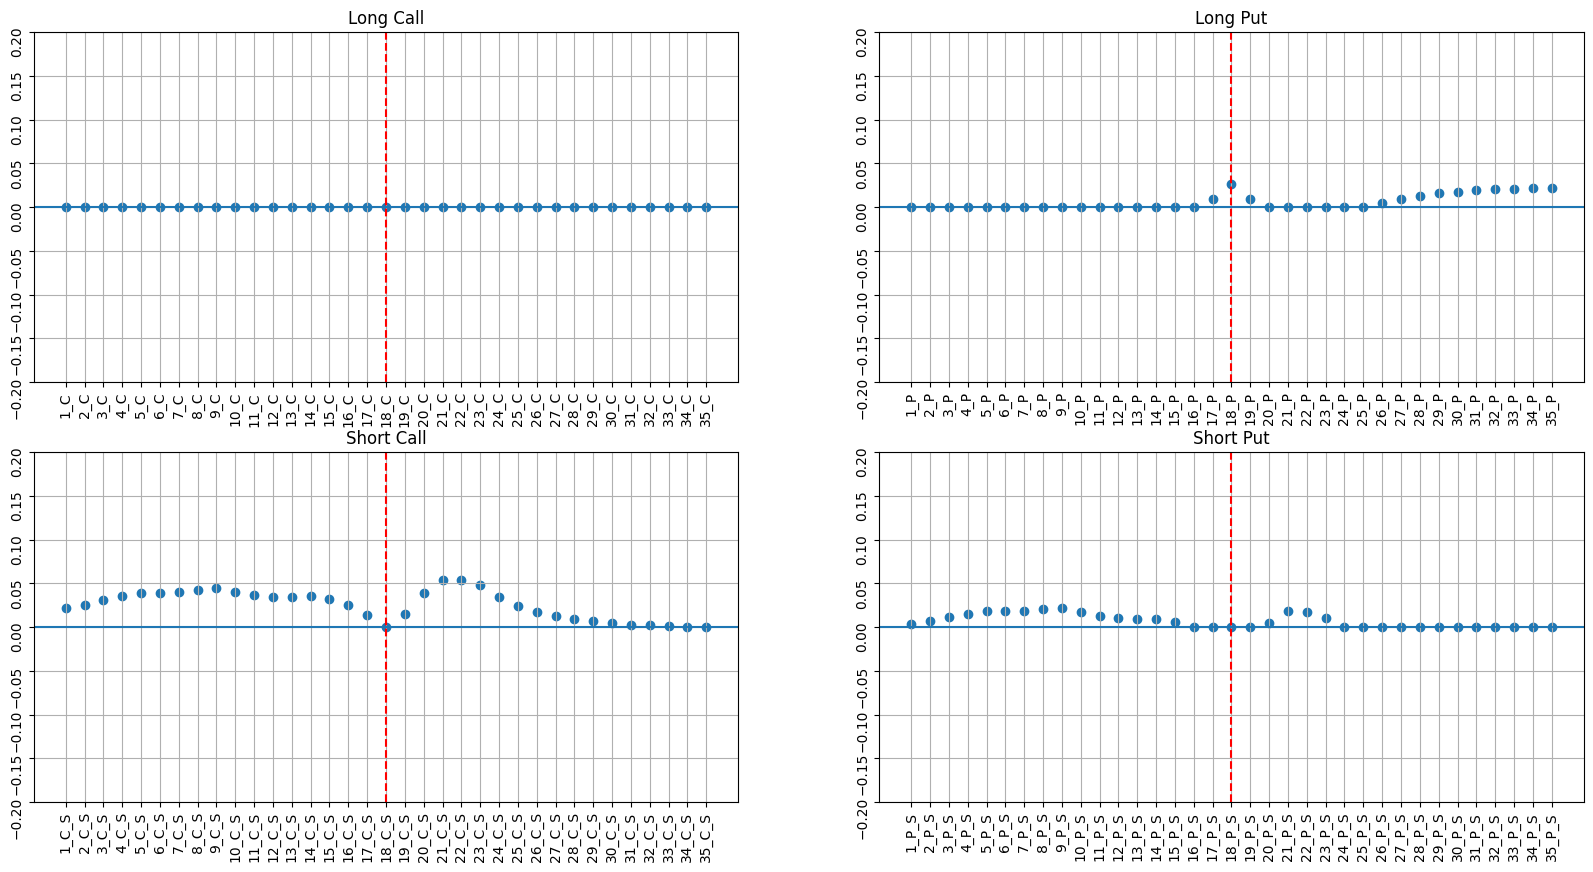

In [4]:
gamma, norm_m = 0.001, 0.2
w = optimize(option_PNL, gamma, norm_m, graph = True, edge = 0.2, verbose=False)

In [5]:
print('norm:', np.sqrt(w.T@w), 'cov:', np.sqrt(w.T@option_PNL.cov()@w))

norm: 0.19999696394495176 cov: 438.067012050792


In [8]:
cov = []
gamma_range = list(np.arange(0.001, 0.005, 0.0005)) + list(np.arange(0.005, 0.01, 0.001))+list(np.arange(0.01,0.1, 0.01))
norm_m = 0.5
for gamma in gamma_range:
    w = optimize(option_PNL, gamma=gamma, norm_m=norm_m, graph = False, edge=0.5, verbose=False)
    cov.append(np.sqrt(w.T@option_PNL.cov()@w))
    # print('\n gamma:', gamma, 'cov:', np.sqrt(w.T@option_PNL.cov()@w))

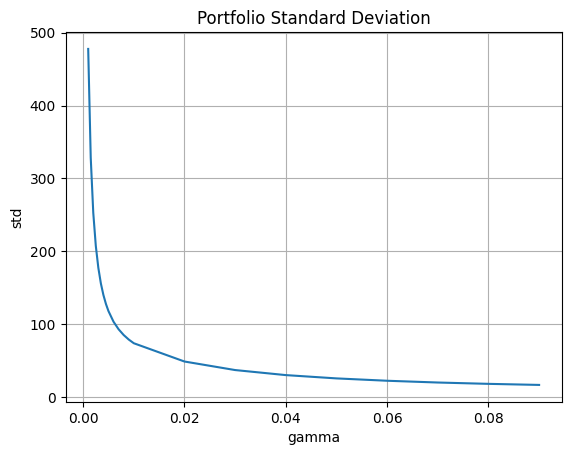

In [7]:
plt.grid()
plt.plot(gamma_range, cov)
plt.xlabel('gamma')
plt.ylabel('std')
plt.title('Portfolio Standard Deviation')
# plt.ylim(0,10,0.1)
plt.show()

In [12]:
gamma, norm_m = 0.001, 0.2
w = optimize(option_PNL, gamma, norm_m, graph = False, edge = 0.2, verbose=False)

In [13]:
mu = option_PNL.mean().to_numpy()
Sigma = option_PNL.cov()
print('fake profit:', w.T @ mu)
print('fake standard deviation:', np.sqrt(w.T @ Sigma @ w))

fake profit: 232.6382685566329
fake standard deviation: 438.067012050792


In [14]:
mu = real_PNL.mean().to_numpy()
Sigma = real_PNL.cov()
print('real profit:', w.T @ mu)
print('real standard deviation:', np.sqrt(w.T @ Sigma @ w))

real profit: -77.07979392843632
real standard deviation: 496.3470151703645


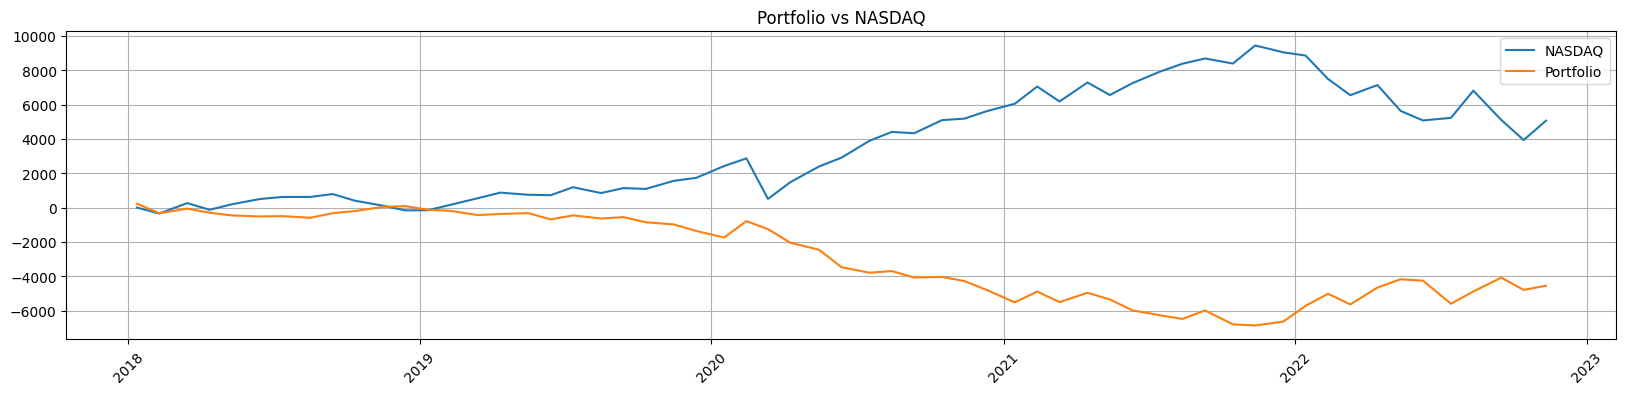

In [17]:
def plot_portfolio_vs_NASDAQ(option_PNL, nasdaq, w_opt): 
    portfolio = np.cumsum(option_PNL@w_opt.T)
    portfolio.index = pd.to_datetime(portfolio.index)   

    nasdaq_1 = nasdaq[nasdaq['Date'].isin(quote_dates)]
    nasdaq_1.set_index('Date', inplace=True)

    plt.figure(figsize=(20,4))
    plt.grid()
    plt.plot(nasdaq_1['Close/Last']-nasdaq_1.loc['2018-01-12', ['Close/Last']].values[0], label='NASDAQ')
    plt.plot(portfolio, label = 'Portfolio')
    plt.xticks(rotation=45)
    plt.legend()
    plt.title('Portfolio vs NASDAQ')
    plt.show()
plot_portfolio_vs_NASDAQ(real_PNL, nasdaq, w)

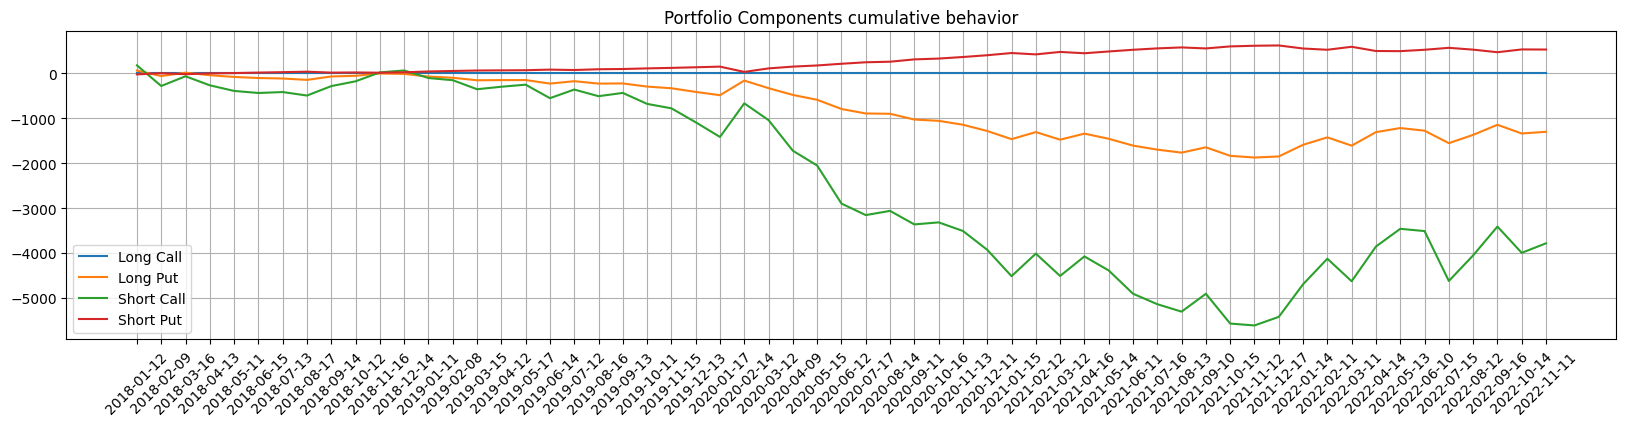

In [18]:
m=35
def plot_component(option_PNL, w_opt):
    plt.figure(figsize=(20,4))
    plt.grid()
    plt.plot(np.cumsum(option_PNL.iloc[:,:m*1]@w_opt[:m*1].T), label='Long Call')
    plt.plot(np.cumsum(option_PNL.iloc[:,m*1:m*2]@w_opt[m*1:m*2].T), label='Long Put')
    plt.plot(np.cumsum(option_PNL.iloc[:,m*2:m*3]@w_opt[m*2:m*3].T), label='Short Call')  
    plt.plot(np.cumsum(option_PNL.iloc[:,m*3:m*4]@w_opt[m*3:m*4].T),label = 'Short Put')
    plt.xticks(rotation=45)
    plt.legend()
    plt.title('Portfolio Components cumulative behavior')
    plt.show()
plot_component(real_PNL, w)